# Ejemplo inspección de los datos, y tratamiento de valores faltantes

Este ejemplo ilustra el uso de las librerías Pandas, MatplotLib, y Seaborn, para cargar un dataset, inspeccionar datos y corregir valores faltantes. El conjunto de datos tomado como ejemplo es: https://www.kaggle.com/uciml/pima-indians-diabetes-database

El objetivo del dataset es diagnosticar si una paciente tiene diabetes o no con base en un conjunto de variables predictoras como son el número de veces de embarazo, concentración de glucosa en sangre, presión sanguínea, y otras más. El conjunto de datos fue construido como mujeres con mínimo 21 años de edad pertenecientes al grupo étnico Pima Indian.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

import warnings

Para cargar el conjunto de datos que se encuentra en un archivo extensión.cvs, se utiliza una función de la libreria Pandas que nos devuelve un DataFrame. Luego con la función info también de Pandas generamos un informe de lo que el archivo de datos contiene.

In [3]:
#Cargando datos
diabetes = pd.read_csv("./sample_data/diabetes.csv")
#Informacion de los datos
print(diabetes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


También podemos generar un resumen estadístico de las variables numéricas del conjunto de datos, utilizando la función describe. Al analizar este resumen estadístico podemos detectar un posibe error en los datos de algunas de las variables predictoras del estudio: Glucose, BloodPressure, SkinThickness, Insulin, y BMI.

In [4]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


El conjunto consiste de dos clases, etiquetadas como 0 para pacientes que no padecen de diabetes, y 1 para pacientes que presentan la enfermedad. Inspeccionemos la distribución de las clases a través de un histograma.



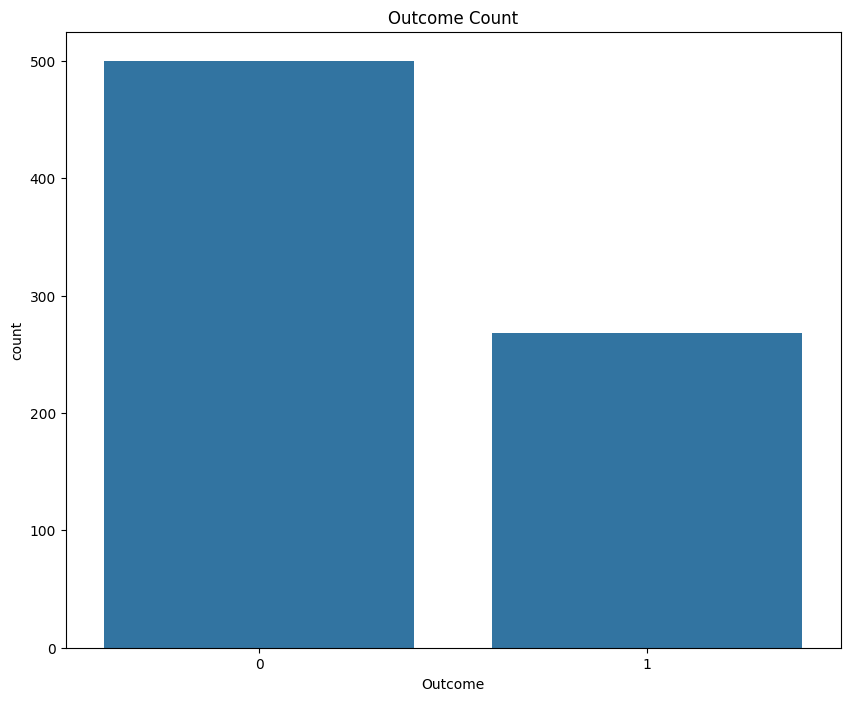

In [5]:
#Histograma del atributo clase
ax=plt.subplots(1,1,figsize=(10,8))
sns.countplot(x='Outcome',data=diabetes)
plt.title("Outcome Count")
plt.show()

Se puede observar que las clases están un poco desbalanceadas; pero ambas clases contienen ejemplos. Inspeccionemos también los histogramas de frecuencia para las variables predictoras de este ejemplo, las cuales también son todas de tipo numérico.

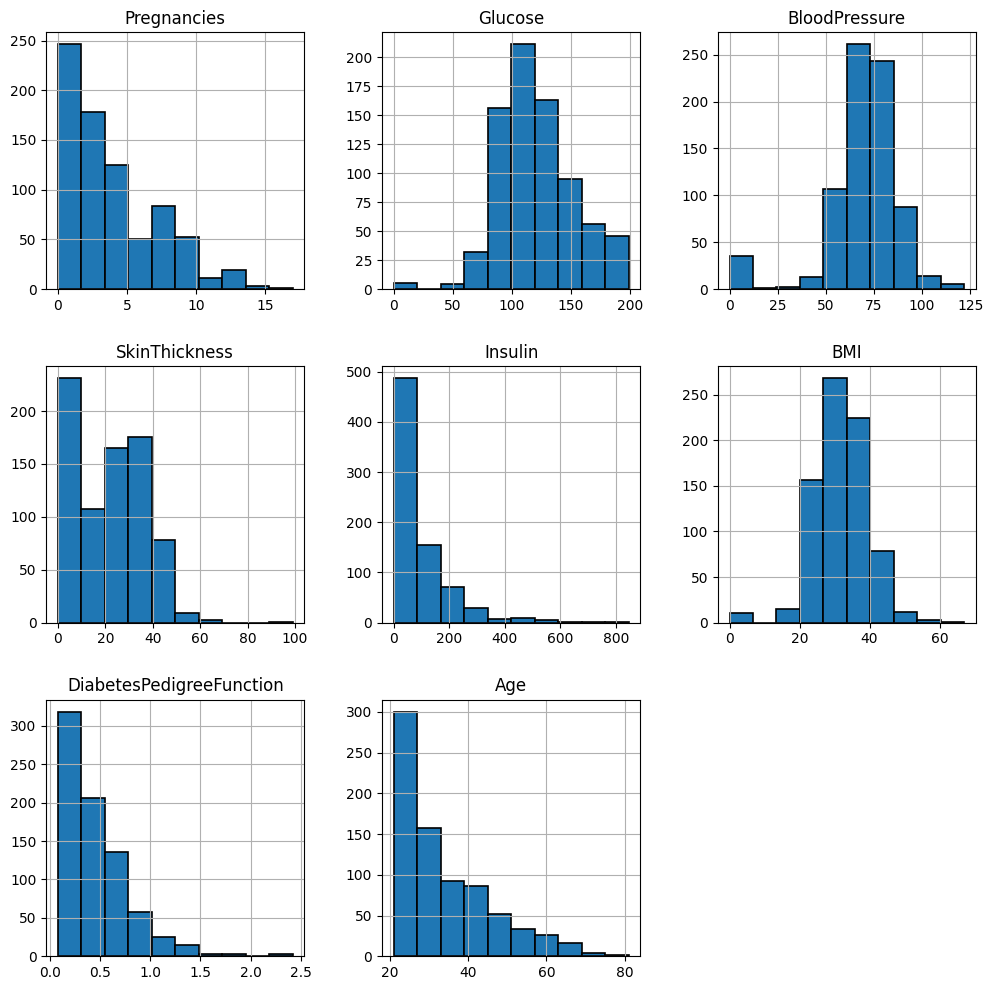

In [10]:
diabetes_var = diabetes.drop(['Outcome'], axis=1)
diabetes_var.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(12,12)
plt.show()

Algunas variables como Glucose, BloodPressure, SkinThickness, Insulin, BMI tienen valores de 0, lo cual no tiene sentido, en los foros de discusión en Kaggle se encuentra que el 0 en estas variables corresponden a valores faltantes. Si tenemos en cuenta que esos casos en 0 son en realidad datos faltantes, veamos cuantos datos faltantes hay en el conjunto de datos.

In [11]:
cols = ['Glucose', 'BloodPressure', 'Insulin', 'BMI', 'SkinThickness']
diabetes[cols] = diabetes[cols].replace({0:np.nan})

diabetes.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

# Corrigiendo datos faltantes

Las siguientes líneas de código muestran como ejemplo diferentes estrategias que se pueden considerar para rellenar datos faltantes en un conjunto de datos.

In [13]:
def fillna_mean_class(df, att, clase):
   mean_val = diabetes.groupby(clase)[att].mean()
   df.loc[df[clase] == 0 & df[att].isnull(), att] = mean_val[0]
   df.loc[df[clase] == 1 & df[att].isnull(), att] = mean_val[1]
   return df

In [14]:
#Ejemplo en el que se rellenan los valores faltantes con el valor medio de acuerdo a la media de la clase
diabetes = fillna_mean_class(diabetes, 'Glucose', 'Outcome')
diabetes = fillna_mean_class(diabetes, 'BloodPressure', 'Outcome')

#Ejemplo en el que se rellenan los valores faltantes con el valor medio de todos los valores del atributo
diabetes['SkinThickness'].fillna(value=diabetes['SkinThickness'].median(), inplace=True)

#Se eliminta la columna por contener muchos valores faltantes
diabetes.drop(['Insulin'], axis=1, inplace=True)

#Se utiliza el método los k vecinos más cercanos para aproximar los valores faltantes, en este caso solo
#quedaba la variable BMI
imputer = KNNImputer(n_neighbors=2)
diabetes = pd.DataFrame(imputer.fit_transform(diabetes), columns=diabetes.columns)

diabetes.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64